## Интеллектуальный анализ данных – весна 2024
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


####**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования. Используйте [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [3]:
X.isnull().values.any()

print(X.select_dtypes(['category', 'object']).columns)

Index([], dtype='object')


Нет пропущенных значений\
Нет категориальных переменных

####**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [4]:
from sklearn.model_selection import train_test_split
np.random.seed(32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32, stratify=y)

Параметр stratify гарантирует, что распределение классов будет равномерным как в тестовой так и в тренировочное выборке = исходной выборке\
Это важно, тк возможна ситуация когда один из классов будет недостаточно представлен в тестовой выборке, что может привести к неправильной оценке качества модели.

####**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
X_train = X_train[['alcohol', 'magnesium']]
X_test = X_test[['alcohol', 'magnesium']]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn_list = []

for k in [1, 3, 5, 10, 15, 25]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_train_pred = knn.predict(X_train_scaled)
    y_test_pred = knn.predict(X_test_scaled)

    acc_on_test = np.mean(y_test==y_test_pred)
    acc_on_train = np.mean(y_train==y_train_pred)
    print(f'''{k}     {acc_on_train:.2f}     {acc_on_test:.2f}\n''')
    knn_list.append(knn)


1     0.99     0.65

3     0.81     0.70

5     0.81     0.69

10     0.79     0.72

15     0.73     0.72

25     0.71     0.69



####**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [6]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [7]:
import mlxtend

####**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

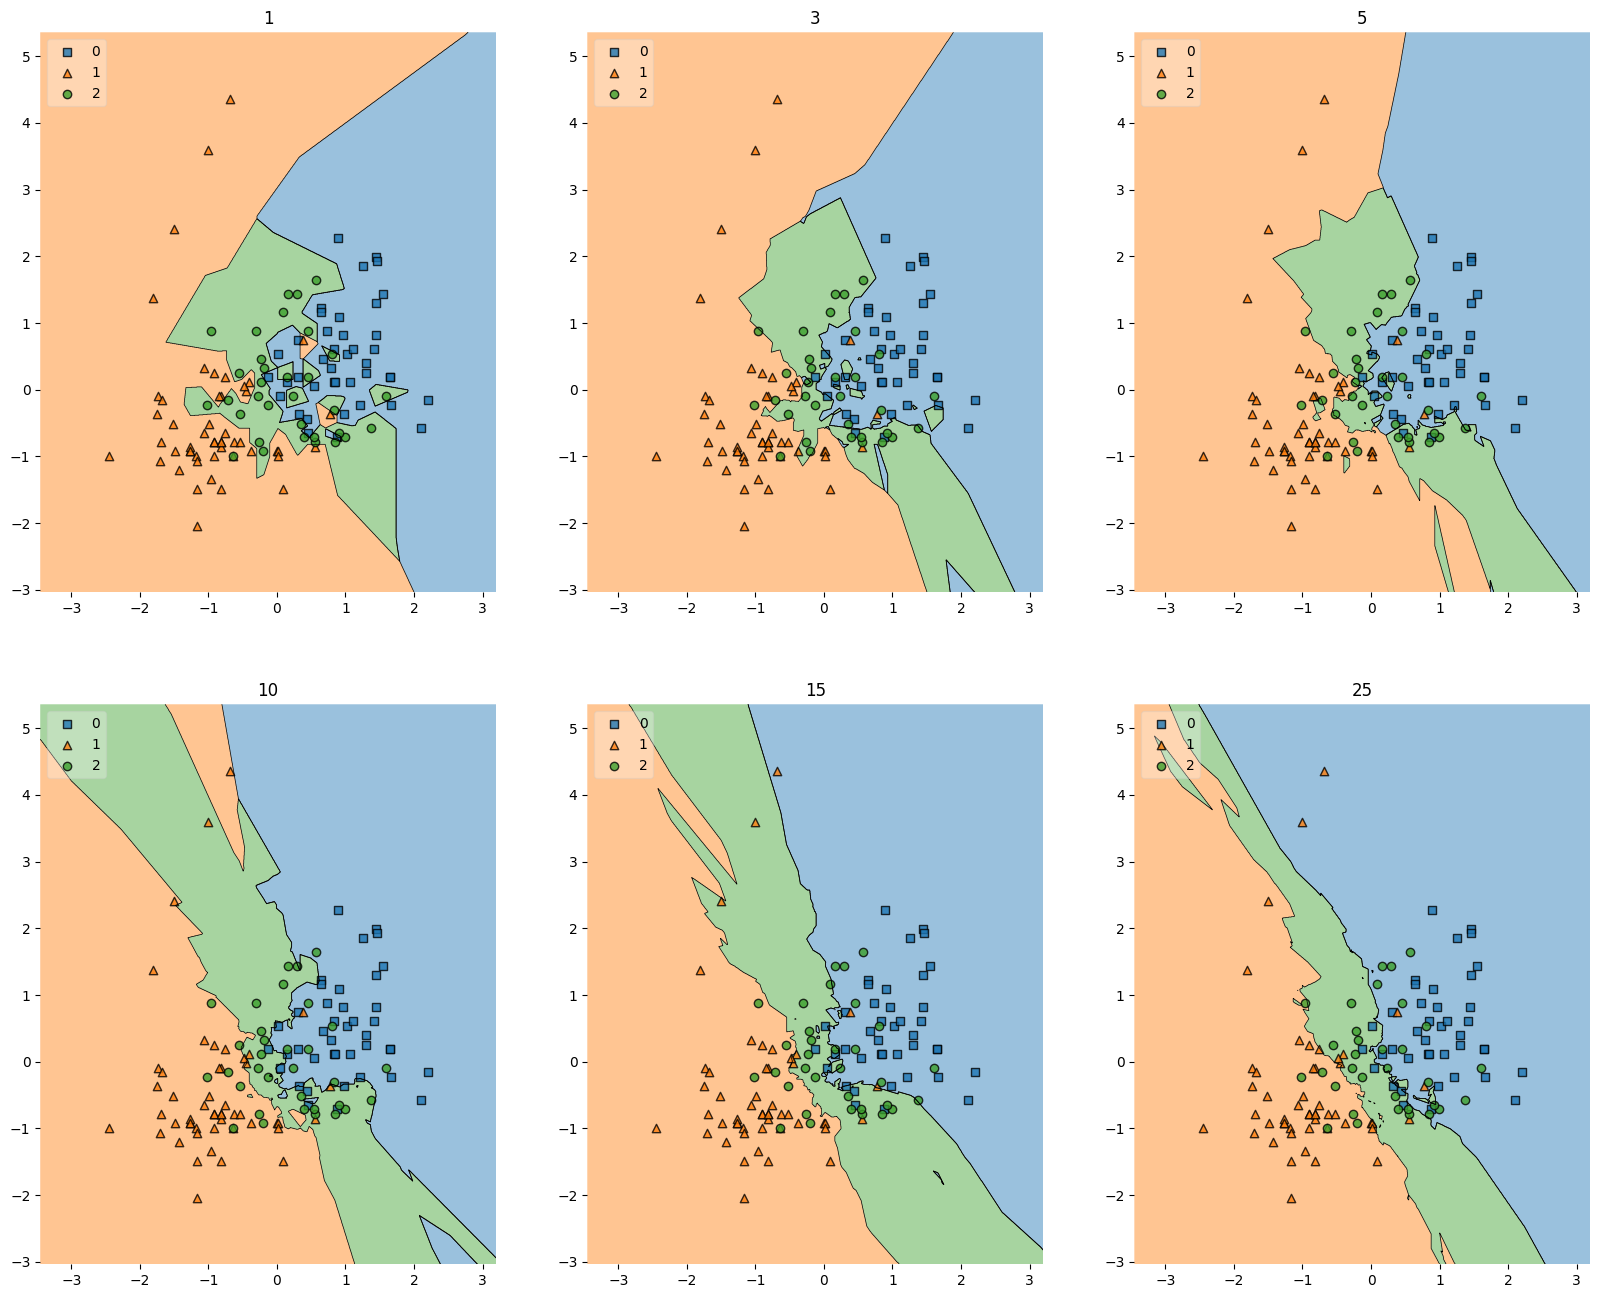

In [8]:
from mlxtend.plotting import plot_decision_regions
from mlxtend.preprocessing import shuffle_arrays_unison
import matplotlib.pyplot as plt
import itertools
from sklearn import datasets

X_train = np.array(X_train_scaled)
y_train = np.array(y_train)

labels = ['1', '3', '5', '10', '15', '25']

fig, axs = plt.subplots(2, 3, figsize=(20, 16))

for clf, lab, grd in zip(knn_list,
                         labels,
                         itertools.product([0, 1, 2], repeat=2)):
    clf.fit(X_train_scaled, y_train)
    plot_decision_regions(X_train, y_train, clf=clf, legend=2, ax=axs[grd[0], grd[1]], scatter_kwargs={'edgecolors': 'k'})
    axs[grd[0], grd[1]].set_title(lab)

plt.show()


####**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

Анализ данных полученных в задании 1.3 позволяет нам определить оптимальное число соседей: 10 и 15, тк результат работы модели на тестовых данных - 72%

Основываясь на геометрии полученных данных, можно сказать, что предположение об оптимальности k = 10, 15  подтверждается.
Действительно, видим, что модель не сильно подстраивается под обучающую выборку и разделение поверхности на 3 класса сравнительно плавное.


### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

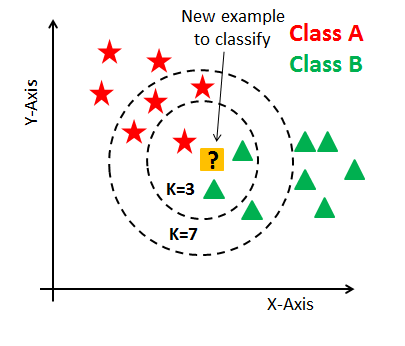

In [9]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k: int):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        array = []
        for i in range(0, len(X)):
            lengths = np.sqrt(np.sum((self.X_train - X[i]) ** 2, axis=1))
            k_nearest_classes = self.y_train[np.argsort(lengths)[:self.k]]
            array.append(Counter(k_nearest_classes).most_common(1)[0][0])

        return np.array(array)

    def count_distance(self, x, y):
        return np.sqrt(np.sum((x - y) ** 2))

In [10]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [11]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [13]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

####**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [14]:
missing_values = data.isnull().sum()
print("Пропущенные значения:")
print(missing_values)

# Удаление пропущенных значений, если они есть
data = data.dropna()
unique_values = data.nunique()
print("\nУникальные значения:")
print(unique_values)

#Уберем Unnamed 0, тк он копирует индексацию
data.drop(['Unnamed: 0'], axis = 1, inplace = True)
data.head(3)

Пропущенные значения:
Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

Уникальные значения:
Unnamed: 0    53940
carat           273
cut               5
color             7
clarity           8
depth           184
table           127
price         11602
x               554
y               552
z               375
dtype: int64


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


####**Задача 3.2 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

Матрица выборочных корреляций с price:
carat    0.921591
depth   -0.010647
table    0.127134
price    1.000000
x        0.884435
y        0.865421
z        0.861249
dtype: float64

Признаки с наибольшей корреляцией с price:
price    1.000000
carat    0.921591
x        0.884435
y        0.865421
z        0.861249
dtype: float64


<Axes: >

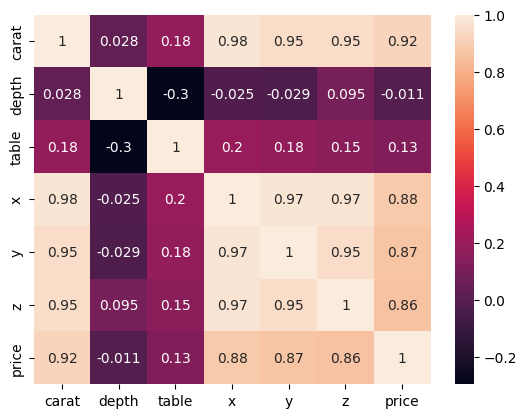

In [15]:
numeric_features = data.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_features.corrwith(data['price'])

print("Матрица выборочных корреляций с price:")
print(correlation_matrix)

max_correlated_features = correlation_matrix.abs().nlargest(5)
print("\nПризнаки с наибольшей корреляцией с price:")
print(max_correlated_features)


#Общая таблица корреляции
sns.heatmap(data[['carat', 'depth', 'table', 'x', 'y', 'z', 'price']].corr(), annot = True)
#Больше всего с price коррелирует carat

####**Задача 3.3 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [17]:
selected_columns = data.select_dtypes(include=['object']).columns
encoded_data = pd.get_dummies(data, columns= selected_columns, drop_first= True)

encoded_data.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


####**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [18]:
X = encoded_data.drop(columns=['price'], axis = 1)
y = encoded_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

# Почему-то со stratify ошибка

####**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

numerical_columns = list(data.select_dtypes(include=['float64']).columns)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

X_train.head(3)

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
35511,-0.817406,1.290192,-0.650469,-0.893064,-0.897014,-0.758306,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6782,0.048948,0.102662,-0.650469,0.232940,0.248832,0.256665,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
42445,-0.479316,-0.386321,-0.201363,-0.374745,-0.332771,-0.391789,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


####**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [20]:
# Создание объекта линейной регрессии
model = LinearRegression()

# Обучение модели на тренировочной выборке
model.fit(X_train_scaled, y_train)

# Предсказание на тренировочной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Вычисление среднеквадратичной ошибки на тренировочной и тестовой выборках
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Вывод среднеквадратичной ошибки
print("Среднеквадратичная ошибка на тренировочной выборке:", mse_train)
print("Среднеквадратичная ошибка на тестовой выборке:", mse_test)


Среднеквадратичная ошибка на тренировочной выборке: 1267336.037887526
Среднеквадратичная ошибка на тестовой выборке: 1299831.7679135192


####**Задача 3.7 (0.2 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [21]:
coefficients = model.coef_

coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

print(coefficients_df)

max_coefficient = coefficients_df['Coefficient'].abs().max()
print("\nВещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных:")
print(coefficients_df[coefficients_df['Coefficient'].abs() > max_coefficient / 10] )


          Feature  Coefficient
0           carat  5397.235762
1           depth  -101.016005
2           table   -58.722355
3               x -1204.453513
4               y    10.629249
5               z   -24.329104
6        cut_Good   163.876653
7       cut_Ideal   412.923850
8     cut_Premium   332.755175
9   cut_Very Good   302.577921
10        color_E   -77.165927
11        color_F  -108.251257
12        color_G  -192.456252
13        color_H  -349.201744
14        color_I  -445.440037
15        color_J  -533.079939
16     clarity_IF   947.908276
17    clarity_SI1  1595.160009
18    clarity_SI2  1030.123579
19    clarity_VS1  1657.256389
20    clarity_VS2  1808.361910
21   clarity_VVS1  1266.105830
22   clarity_VVS2  1472.014027

Вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных:
         Feature  Coefficient
0          carat  5397.235762
3              x -1204.453513
16    clarity_IF   947.908276
17   clarit

####**Задача 3.8 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [22]:
from sklearn.linear_model import Lasso, Ridge
alphas = [0.1, 1, 10, 100, 200]
lasso_regressor = Lasso(alpha=10)
ridge_regressor = Ridge(alpha=10)

lasso_regressor.fit(X_train, y_train)
ridge_regressor.fit(X_train, y_train)


coefficients_lasso = lasso_regressor.coef_
coefficients_ridge = ridge_regressor.coef_

print(coefficients_lasso, '\n')
print(coefficients_ridge)


[ 4773.24883486  -161.55209586  -107.49168532  -712.4435429
    -0.           -12.12397061    -0.           180.15951195
    81.14675232    92.53262172     8.22223602    -0.
  -104.86240298  -587.04973362  -996.25636819 -1809.76484722
  1293.02957809    21.73869397  -784.0948522    836.45181823
   607.39670234  1175.25356767  1203.09303033] 

[ 5339.92539969  -103.88752463   -61.67556398 -1158.12244576
    10.66763911   -26.34888689   599.93929252   872.98651937
   788.21175791   757.99463976  -188.34011775  -270.20327345
  -455.34329758  -949.00147628 -1449.05583447 -2380.8515667
  4773.68153016  3170.50824271  2209.42604403  4062.28946101
  3767.99273687  4479.26375174  4445.90157132]



Ответ на вопрос: веса стали меньше. Таким образом, мультиколлинеарность очень сильно проявлялась в изначальной модели, поскольку существуют определенные переменные, сильно коррелирующие с другими.\
Это приводит к тому, что значения одних коэффициентов значительно зависят от других.

####**Задача 3.9 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

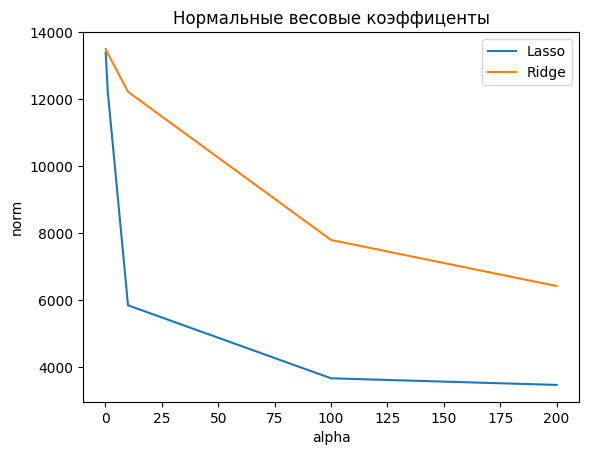

In [23]:
plt.plot(alphas, [np.linalg.norm(Lasso(alpha=alpha).fit(X_train, y_train).coef_) for alpha in alphas], label='Lasso')
plt.plot(alphas, [np.linalg.norm(Ridge(alpha=alpha).fit(X_train, y_train).coef_) for alpha in alphas], label='Ridge')
plt.xlabel('alpha')
plt.ylabel('norm')
plt.title('Нормальные весовые коэффиценты')
plt.legend()
plt.show()

Лассо регрессия сильнее уменьшает веса. Кроме того, коэффициенты для некоторых признаков будут зануляться, что приводит к отбору наиболее релевантных, влияющих на целевую переменную признаков, игнорируя несущественные признаки.

####**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [24]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

errors = lasso_cv.mse_path_

optimal_alpha = lasso_cv.alphas_[np.argmin(np.mean(errors, axis=1))]

print("Оптимальное значение alpha:", optimal_alpha)


Оптимальное значение alpha: 0.1


####**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [25]:
lasso_final = Lasso(alpha=optimal_alpha)

lasso_final.fit(X_train_scaled, y_train)

coefficients_final_df = pd.DataFrame({'Feature': X.columns, 'Coefficient':  lasso_final.coef_})

least_informative_features = coefficients_final_df[coefficients_final_df['Coefficient'].abs() < 1e-6]
most_informative_features = coefficients_final_df[coefficients_final_df['Coefficient'].abs() >= 1e-6]

print("\nНаименее информативные признаки:")
print(least_informative_features)
print("\nНаиболее информативные признаки:")
print(most_informative_features)

# Проанализируем признаки и их коэффициенты:
# Если коэффициент близок к нулю, то это говорит о том, что признак не оказывает значимого влияния на целевую переменную.
# Признаки с нулевыми или близкими к нулю коэффициентами можно считать неинформативными.
# Признаки с ненулевыми коэффициентами считаются информативными, так как они оказывают влияние на целевую переменную.


Наименее информативные признаки:
Empty DataFrame
Columns: [Feature, Coefficient]
Index: []

Наиболее информативные признаки:
          Feature  Coefficient
0           carat  5391.753420
1           depth  -101.116199
2           table   -58.843586
3               x -1197.157093
4               y     7.959275
5               z   -24.001545
6        cut_Good   162.728704
7       cut_Ideal   410.987284
8     cut_Premium   330.969164
9   cut_Very Good   301.010016
10        color_E   -76.451519
11        color_F  -107.581778
12        color_G  -191.672302
13        color_H  -348.462613
14        color_I  -444.701378
15        color_J  -532.465980
16     clarity_IF   944.820079
17    clarity_SI1  1587.812847
18    clarity_SI2  1023.783446
19    clarity_VS1  1651.046274
20    clarity_VS2  1801.210060
21   clarity_VVS1  1261.787807
22   clarity_VVS2  1466.967351


####**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [26]:
# Предсказания обученной Lasso-регрессии на тестовой выборке
y_test_pred_lasso = lasso_final.predict(X_test_scaled)

# Вычисление среднеквадратичной ошибки Lasso-регрессии
mse_test_lasso = mean_squared_error(y_test, y_test_pred_lasso)

# Среднеквадратичная ошибка обычной линейной регрессии уже была вычислена в задаче 3.7

# Вывод результатов сравнения ошибок
print("Среднеквадратичная ошибка обычной линейной регрессии на тестовой выборке:", mse_test)
print("Среднеквадратичная ошибка Lasso-регрессии на тестовой выборке:", mse_test_lasso)

# Вывод рекомендации
if mse_test_lasso < mse_test:
    print("\nЛучше использовать Lasso-регрессию для предсказаний.")
else:
    print("\nЛучше использовать обычную линейную регрессию для предсказаний.")


Среднеквадратичная ошибка обычной линейной регрессии на тестовой выборке: 1299831.7679135192
Среднеквадратичная ошибка Lasso-регрессии на тестовой выборке: 1299653.0536346675

Лучше использовать Lasso-регрессию для предсказаний.
